# MNIST Image Classification - Ludwig CLI

*We recommend using a GPU runtime for this example. In the Colab menu bar, choose **Runtime** > **Change Runtime Type** and choose **GPU** under Hardware Accelerator.*

In this notebook, we will show how to use the Ludwig CLI to:


1.   [Download a Dataset](#scrollTo=Download_Dataset)
2.   [Train a Ludwig Model](#scrollTo=Train)
3.   [Evaluate the trained model](#scrollTo=Evaluate)
4.   [Visualize training and test metrics](#scrollTo=Visualize_Metrics)
5.   [Make predictions on New Data](#scrollTo=Make_Predictions_on_New_Data)

In [1]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 398 kB 8.2 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 136 kB 44.8 MB/s 
     |████████████████████████████████| 1.1 MB 41.3 MB/s 
     |████████████████████████████████| 94 kB 1.5 MB/s 
     |████████████████████████████████| 271 kB 49.0 MB/s 
     |████████████████████████████████| 144 kB 45.6 MB/s 


# Download Dataset

MNIST is a collection of gray-scale images of hand-written digits.  This collection is made up of 60,000 images for training and 10,000 images for testing model performance.  

After downloading the the images, a single csv file is created in the working directory for this notebook.


This dataset contains three columns:

| column      | description                                                |
|-------------|------------------------------------------------------------|
| image_path  | File path string to an image. |
| label       | Integer variable indicating the image's digit (0, 1, 2, ..., 9) |
| split       | Integer indicating whether this record is part of the training data (0) or test data (2) |


In [2]:
# Downloads the MNIST Dataset into the current directory.
!ludwig datasets download mnist

NumExpr defaulting to 2 threads.
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Datasets download

train-images-idx3-ubyte.gz: 9.46MB [00:00, 38.1MB/s]                
train-labels-idx1-ubyte.gz: 32.0kB [00:00, 441kB/s]
t10k-images-idx3-ubyte.gz: 1.58MB [00:00, 14.5MB/s]               
t10k-labels-idx1-ubyte.gz: 8.00kB [00:00, 206kB/s]
>>> create ludwig formatted training data
>>> create ludwig formatted testing data
>>> completed data preparation


# Display sample data

## Helper function to display images
This function can display up to 30 images.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotDigitGrid(X,y,idxs,y_hat=None):
    plt.figure(figsize=(14,12))

    for i in range(len(idxs)):
        plt.subplot(5,6,i+1)
        
        if y_hat is None:
            plt.title('label: {label}'.format(label=y[idxs[i]]))
        else:
            plt.title("label: {label}  pred: {pred}".format(label=y[idxs[i]], pred=y_hat[idxs[i]]))

        plt.imshow(X[idxs[i]], cmap='Greys')
        plt.tick_params(
            axis='both',          # changes apply to the x-axis and y-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # tick marks on bottom side are off
            left=False,        # tick marks on left side are off
            labelleft=False,   # label on left side are off
            labelbottom=False) # labels along the bottom edge are off
        plt.subplots_adjust(hspace=0.5)

    plt.show()

In [4]:
import pandas as pd
import numpy as np

np.random.seed(31)
pd.set_option("display.max_colwidth", 80)
# display sample of image dataset
sample_df = pd.read_csv('./mnist_dataset.csv').sample(n=30)
sample_df.head(5)

,image_path,label,split
65573,/root/.ludwig_cache/mnist_1.0/processed/testing/5/6775.png,5,2
34803,/root/.ludwig_cache/mnist_1.0/processed/training/5/49785.png,5,0
53398,/root/.ludwig_cache/mnist_1.0/processed/training/8/7836.png,8,0
11430,/root/.ludwig_cache/mnist_1.0/processed/training/1/27388.png,1,0
39980,/root/.ludwig_cache/mnist_1.0/processed/training/6/5877.png,6,0


# Display Sample Training Images with Associated Labels

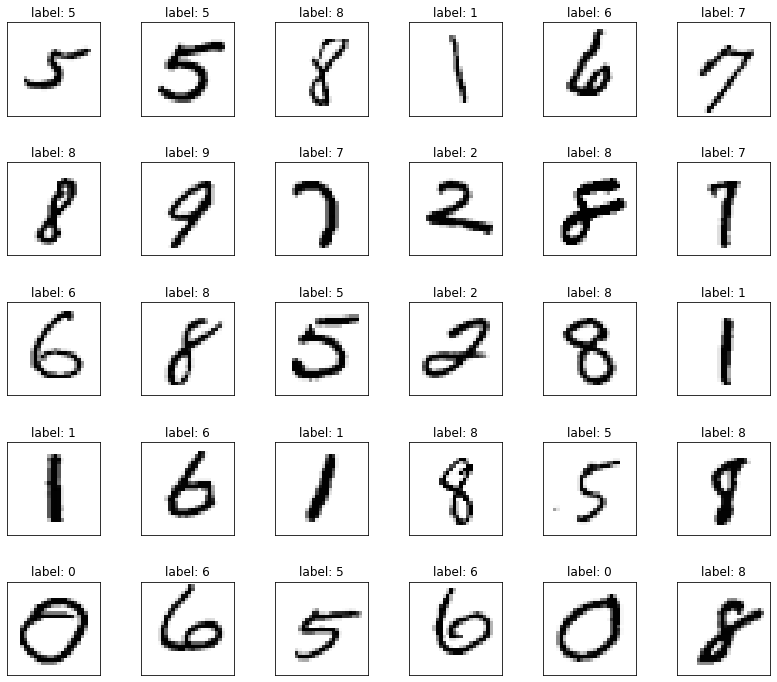

In [5]:
# add image array to the sample dataframe
sample_df['image'] = sample_df['image_path'].apply(plt.imread)

# plot the sample data
plotDigitGrid(sample_df["image"],sample_df["label"],sample_df.index)

# Train

## Define ludwig config

The Ludwig config declares the machine learning task. It tells Ludwig what to predict, what columns to use as input, and optionally specifies the model type and hyperparameters.

We are going to attempt to predict the label from the image.

In [6]:
config_yaml = """
input_features:
  - name: image_path
    type: image
    preprocessing:
      num_processes: 4
    encoder: stacked_cnn
    conv_layers:
      - num_filters: 32
        filter_size: 3
        pool_size: 2
        pool_stride: 2
      - num_filters: 64
        filter_size: 3
        pool_size: 2
        pool_stride: 2
        dropout: 0.4
    fc_layers:
      - output_size: 128
        dropout: 0.4

output_features:
  - name: label
    type: category

trainer:
  epochs: 5
"""

# Writes config to a file called "config.yaml"
with open("config.yaml", "w") as f:
  f.write(config_yaml)

## Create and train a model

In [7]:
# Trains the model. This cell might take a few minutes.
!ludwig train --dataset mnist_dataset.csv \
              --config config.yaml

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Train


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ experiment                                                                     │
├──────────────────┼────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                            │
├──────────────────┼────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/experiment_run                                                │
├──────────────────┼────

# Evaluate

In [8]:
# Generates predictions and performance statistics for the test set.
!ludwig evaluate --model_path results/experiment_run/model \
                 --dataset mnist_dataset.csv \
                 --split test \
                 --output_directory test_results

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Evaluate

Dataset path: mnist_dataset.csv
Model path: results/experiment_run/model

Loading metadata from: results/experiment_run/model/training_set_metadata.json
Using in_memory = False is not supported with csv data format.
Evaluation: 100% 79/79 [00:00<00:00, 122.00it/s]

===== label =====
accuracy: 0.9897000193595886
hits_at_k: 0.9998000264167786
loss: 0.03312129154801369
overall_stats: { 'avg_f1_score_macro': 0.989635524830299,
  'avg_f1_score_micro': 0.9897,
  'avg_f1_score_weighted': 0.9896899021963079,
  'avg_precision_macro': 0.9897487483591281,
  'avg_precision_micro': 0.9897,
  'avg_precision_weighted': 0.9897,
  'avg_recall_macro': 0.9895759867045559,
  'avg_recall_micro': 0.9897,
  'avg_recall_weighted':

# Visualize Metrics

In [9]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
!ludwig visualize --visualization confusion_matrix \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --test_statistics test_results/test_statistics.json \
                  --output_directory visualizations \
                  --file_format png


# If you run ludwig visualize locally, visualizations will automatically show in
# a window. Here in Colab, we can run the following code to load and display
# generated plots inline.
from IPython import display
import ipywidgets
from pathlib import Path

ipywidgets.HBox([
  ipywidgets.Image(value=Path("visualizations/confusion_matrix__label_top11.png").read_bytes()),
  ipywidgets.Image(value=Path("visualizations/confusion_matrix_entropy__label_top11.png").read_bytes()),
])

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


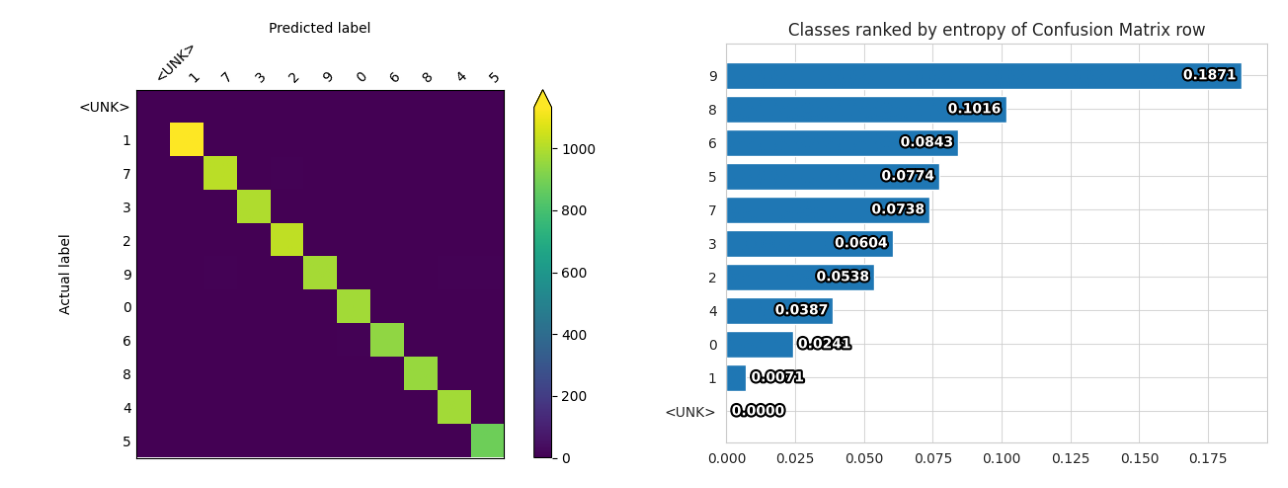

In [10]:
# setup figure for plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 14))

# file paths of the generated plots
plot_fps = ["visualizations/confusion_matrix__label_top11.png", "visualizations/confusion_matrix_entropy__label_top11.png"]

# dispaly learning curve plots
for fp, ax in zip(plot_fps, np.ravel(axs)):
  ax.imshow(plt.imread(fp))
  ax.axis('off')
  ax.tick_params(
    axis='both',       # changes apply to the x-axis and y-axis,
    which='both',      # both major and minor ticks are affected
    bottom=False,      # tick marks on bottom side are off
    left=False,        # tick marks on left side are off
    labelleft=False,   # label on left side are off
    labelbottom=False  # labels along the bottom edge are off
  )

fig.tight_layout()
plt.show()

In [11]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
!ludwig visualize --visualization learning_curves \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --training_statistics results/experiment_run/training_statistics.json \
                  --file_format png \
                  --output_directory visualizations


# If you run ludwig visualize locally, visualizations will automatically show in
# a window. Here in Colab, we can run the following code to load and display
# generated plots inline.
from IPython import display
import ipywidgets
from pathlib import Path

ipywidgets.VBox([
  ipywidgets.HBox([
    ipywidgets.Image(value=Path("visualizations/learning_curves_combined_loss.png").read_bytes()),
    ipywidgets.Image(value=Path("visualizations/learning_curves_label_loss.png").read_bytes()),
  ]),
  ipywidgets.HBox([
    ipywidgets.Image(value=Path("visualizations/learning_curves_label_accuracy.png").read_bytes()),
    ipywidgets.Image(value=Path("visualizations/learning_curves_label_hits_at_k.png").read_bytes())
  ]),
])

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


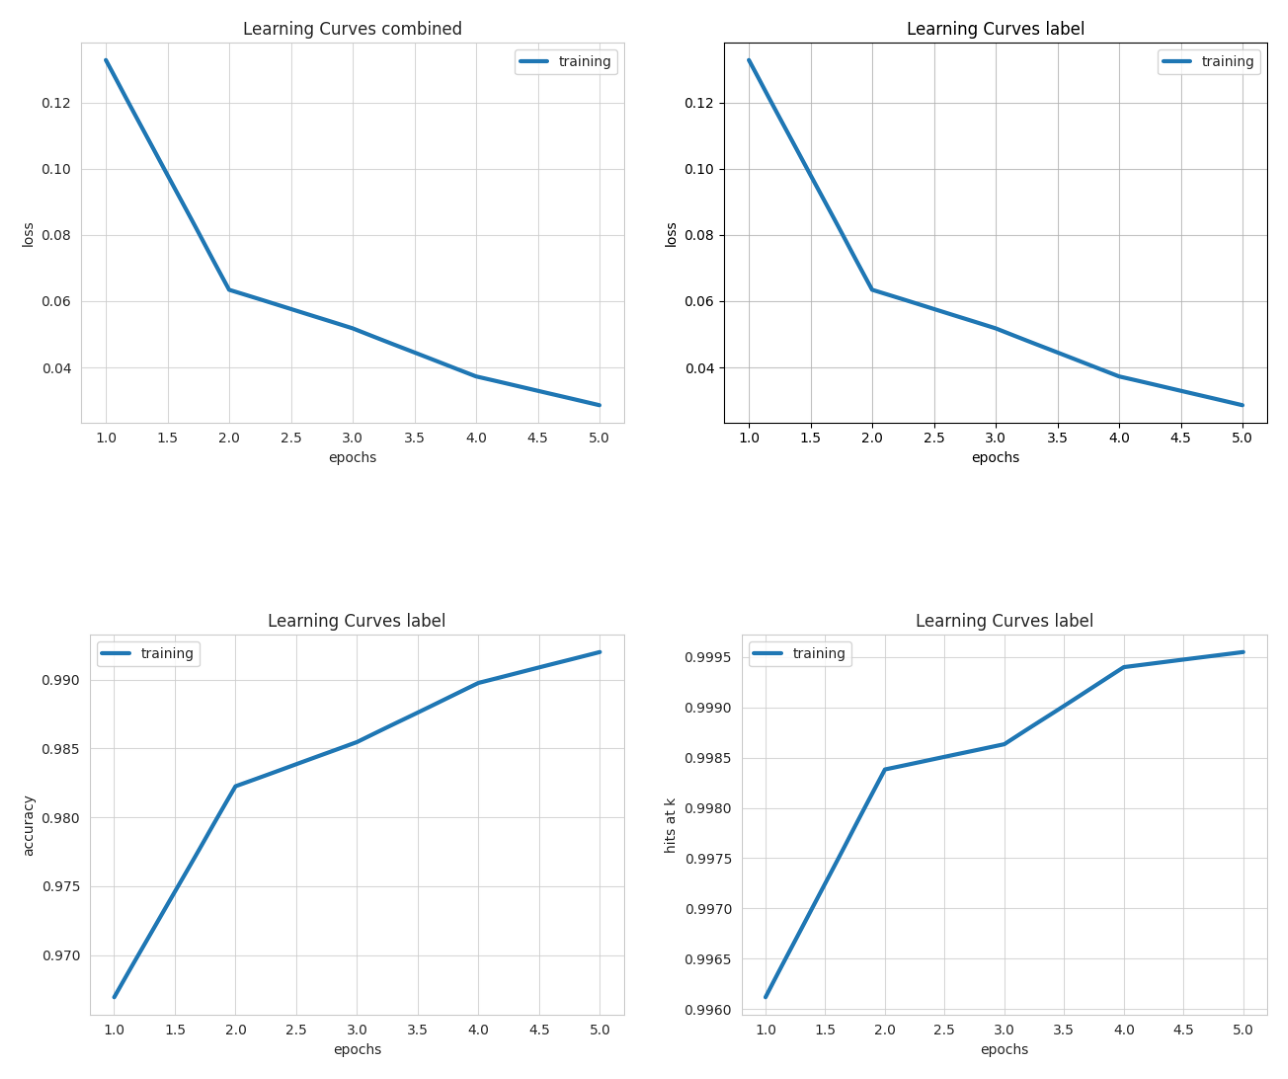

In [12]:
# setup figure for plotting
fig, axs = plt.subplots(2, 2, figsize=(18, 18))

# file paths of the generated plots
plot_fps = ["visualizations/learning_curves_combined_loss.png", "visualizations/learning_curves_label_loss.png",
            "visualizations/learning_curves_label_accuracy.png", "visualizations/learning_curves_label_hits_at_k.png"]

# dispaly learning curve plots
for fp, ax in zip(plot_fps, np.ravel(axs)):
  ax.imshow(plt.imread(fp))
  ax.axis('off')
  ax.tick_params(
    axis='both',       # changes apply to the x-axis and y-axis,
    which='both',      # both major and minor ticks are affected
    bottom=False,      # tick marks on bottom side are off
    left=False,        # tick marks on left side are off
    labelleft=False,   # label on left side are off
    labelbottom=False  # labels along the bottom edge are off
  )

fig.tight_layout()
plt.show()

# Make Predictions on New Data

Lastly we'll show how to generate predictions for new data.

The following will make predictions on the images in the test dataset.

In [13]:
!ludwig predict --model_path results/experiment_run/model \
                --dataset mnist_dataset.csv \
                --split test \
                --output_directory predictions

# Loads predictions
predictions = pd.read_parquet('predictions/predictions.parquet')

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Predict

Dataset path: mnist_dataset.csv
Model path: results/experiment_run/model

Loading metadata from: results/experiment_run/model/training_set_metadata.json
Using in_memory = False is not supported with csv data format.
Prediction: 100% 79/79 [00:00<00:00, 337.88it/s]
Saved to: predictions


# Combine test data with predictions

In [14]:
test_df = pd.read_csv("./mnist_dataset.csv")
test_df = test_df.loc[test_df.split == 2]

# combine test data with predictions
predictions.index = test_df.index

# combine test image data with predictions
predictions = pd.merge(test_df, predictions, left_index=True, right_index=True)

# Extract sample of 30 test images and predictions for display

In [15]:
np.random.seed(123)
sample_test_df = predictions.sample(n=30)
sample_test_df.head()

,image_path,label,split,label_predictions,label_probabilities,label_probability,label_probabilities_<UNK>,label_probabilities_1,label_probabilities_7,label_probabilities_3,label_probabilities_2,label_probabilities_9,label_probabilities_0,label_probabilities_6,label_probabilities_8,label_probabilities_4,label_probabilities_5
62656,/root/.ludwig_cache/mnist_1.0/processed/testing/2/1546.png,2,2,2,"[7.576632299333141e-08, 1.870997584774159e-05, 2.2888531020726077e-05, 0.000...",0.999801,7.576632e-08,1.870998e-05,2.288853e-05,1.327810e-04,9.998006e-01,7.150489e-08,1.180472e-06,7.359790e-08,2.269800e-05,1.414501e-07,8.475903e-07
60445,/root/.ludwig_cache/mnist_1.0/processed/testing/0/4999.png,0,2,0,"[9.23138648856181e-12, 2.5531123881705753e-09, 1.367942701335778e-07, 5.9923...",0.999997,9.231386e-12,2.553112e-09,1.367943e-07,5.992358e-10,1.583346e-08,4.875002e-08,9.999971e-01,9.060903e-08,1.149449e-08,8.708521e-11,2.606550e-06
69505,/root/.ludwig_cache/mnist_1.0/processed/testing/9/2161.png,9,2,9,"[1.0884909897868056e-06, 3.2735317745391512e-06, 0.012943935580551624, 0.000...",0.942663,1.088491e-06,3.273532e-06,1.294394e-02,1.559535e-04,3.814321e-06,9.426631e-01,6.897022e-06,9.777457e-09,1.052079e-04,4.402652e-02,9.018007e-05
60332,/root/.ludwig_cache/mnist_1.0/processed/testing/0/246.png,0,2,0,"[1.4511358337188085e-08, 5.6811611415241714e-08, 1.2161909523911163e-07, 6.1...",0.999947,1.451136e-08,5.681161e-08,1.216191e-07,6.178085e-08,6.224433e-06,1.598206e-05,9.999466e-01,2.377678e-05,1.089711e-06,9.356742e-08,6.028413e-06
64168,/root/.ludwig_cache/mnist_1.0/processed/testing/4/1342.png,4,2,4,"[1.1801352950424615e-10, 1.5967094668667414e-06, 6.360951942951942e-07, 6.85...",0.999996,1.180135e-10,1.596709e-06,6.360952e-07,6.859569e-10,2.241007e-07,4.954401e-07,9.654912e-09,5.193316e-07,2.885107e-07,9.999962e-01,1.379775e-07


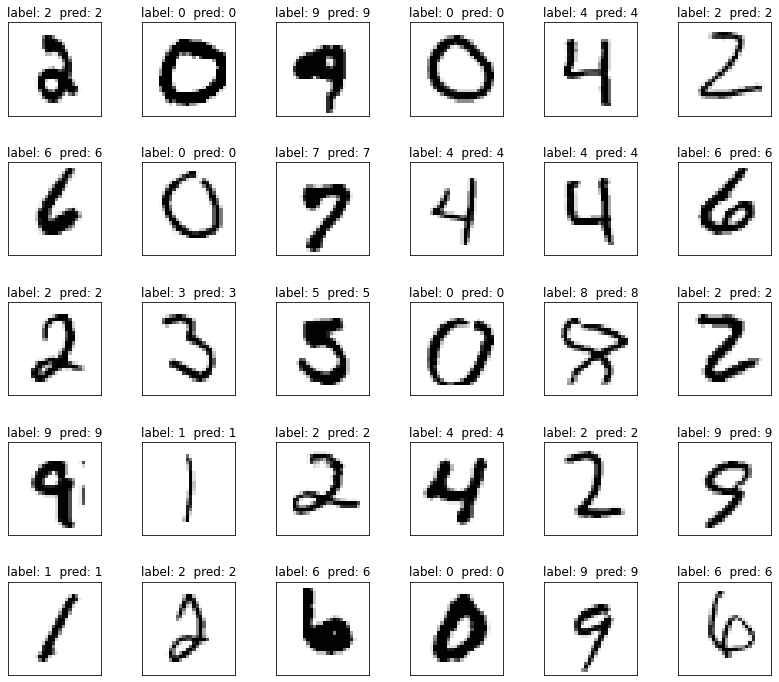

In [16]:
# add image array to the sample dataframe
sample_test_df['image'] = sample_test_df['image_path'].apply(plt.imread)

# plot the sample data
plotDigitGrid(sample_test_df["image"],sample_test_df["label"],sample_test_df.index, y_hat=sample_test_df["label_predictions"])